### Small training example demonstrating the visualizations

In this notebook we show few small networks that learn the available data. The goal is to "beat" the Zero predictor and that required few iterations on manual hyperparameter search. It is possible to find better models but no
computing power was invested on this sample.

Note that the Delay based networks have few orders of magnitude fewer parameters than those presented in the paper.  Also, except dropping learning rate there are no fancy callbacks.

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from pathlib import Path

import torch
from fastai.data.transforms import TfmdLists, DataLoaders
import fastai.learner
import fastai.callback.schedule
import fastai.callback.tracker
import fastai.basics
import fastai.losses


import network_definitions

In [2]:
data_load_path = Path("../data_sample")
train_data = np.load(data_load_path / "train_samples.npy")
valid_data = np.load(data_load_path / "valid_samples.npy")
train_samples = list(train_data)  # to match the requirements of fastai.TfmdLists
valid_samples = list(valid_data)

sample_length = train_data[0].shape[0]
# Settings to match the paper experiments. Except the number of columns, all the settings are the same.
future_length = 30
past_length = sample_length - future_length
no_features = train_data[0].shape[1]
known_column_indexes = list(range(no_features))  # [0, 1, 2, 3]
command_indexes = [2]
target_indexes = [3]
feature_groups = [(0, 1, 3)]
average_range = 0.2
batch_size = 32

feature_itemizer = network_definitions.FeatureItemizer(future_length, known_column_indexes,
                                         command_indexes, target_indexes, feature_groups, average_range)
tls_train = TfmdLists(train_samples, [feature_itemizer])
tls_valid = TfmdLists(valid_samples, [feature_itemizer])
data_dloader = DataLoaders.from_dsets(tls_train, tls_valid, bs=batch_size, drop_last=True, shuffle=True, num_workers=0, device=torch.device("cuda"))
print(f"Data volumes: Train: {len(train_samples)}, Validation: {len(valid_samples)}")

Data volumes: Train: 7255, Validation: 1073


In [3]:
def get_SAffAffGau():
    model = network_definitions.ConstructDelayNet(no_features, len(command_indexes), len(target_indexes), past_length, future_length,
                                                 filter_low_classname="AffineTransform", filter_low_filter_count=4, filter_low_one_kernel_per_feature=True,
                                                 aggregator_low_expansion=0.2, aggregator_low_layers=2, aggregator_low_out_bottleneck=8,
                                                 temporal_contractor_classname="AffineTransform",
                                                 filter_high_classname="GaussFilter", filter_high_filter_count=1, filter_high_one_kernel_per_feature=True, 
                                                 aggregator_high_expansion=0.5, aggregator_high_layers=2)
    return model

def get_SLogAffGau():
    model = network_definitions.ConstructDelayNet(no_features, len(command_indexes), len(target_indexes), past_length, future_length,
                                                 filter_low_classname="LogGauss", filter_low_filter_count=4, filter_low_one_kernel_per_feature=True,
                                                 aggregator_low_expansion=0.2, aggregator_low_layers=4, aggregator_low_out_bottleneck=8,
                                                 temporal_contractor_classname="AffineTransform",
                                                 filter_high_classname="GaussFilter", filter_high_filter_count=1, filter_high_one_kernel_per_feature=True, 
                                                 aggregator_high_expansion=0.5, aggregator_high_layers=2)
    return model

def get_AttA1():
    model = network_definitions.ICCP_Wrap_AttentionModel(no_features, len(command_indexes), len(target_indexes), past_length, future_length,
                                                         hidden_size=8, num_layers=4, dropout=0.35)
    return model

def instantiate_learner(model, data_loader):
    learner = fastai.learner.Learner(data_loader, model, loss_func=fastai.losses.L1LossFlat(),
                     cbs=[fastai.callback.tracker.ReduceLROnPlateau(patience=10, factor=5),
                          fastai.callback.tracker.EarlyStoppingCallback(patience=30),
                          fastai.callback.tracker.SaveModelCallback(fname="best_model_small"),
                          fastai.callback.tracker.TerminateOnNaNCallback(),
                           ],)
    return learner

def evaluate_learner(crt_learner, samples):
    raw_preds, raw_targets = crt_learner.get_preds()
    eval_itemset_arr = np.array(samples)
    feature_itemizer = crt_learner.dls[0].fs[0]
    future_temp_pred_transf = network_definitions.decode_predictions_from_the_network(raw_preds, eval_itemset_arr, feature_itemizer)
    future_temp_target_transf = network_definitions.decode_predictions_from_the_network(raw_targets, eval_itemset_arr, feature_itemizer)
    mae = np.average(np.abs(future_temp_target_transf[:, -future_length:] - future_temp_pred_transf[:, -future_length:]))
    mae_wrt_to_time = np.average(np.abs(future_temp_target_transf[:, -future_length:] - future_temp_pred_transf[:, -future_length:]), axis=0)
    return mae, mae_wrt_to_time, future_temp_pred_transf, future_temp_target_transf

In [4]:
model_names = []
learners = []
global_lr_rate = 1e-3
global_no_max_epochs = 50

### Perform training on all networks

In [5]:
SAffAffGau_learner = instantiate_learner(get_SAffAffGau(), data_dloader)
SAffAffGau_learner.fit_one_cycle(global_no_max_epochs, global_lr_rate)
model_names.append("SAffAffGau")
learners.append(SAffAffGau_learner)

epoch,train_loss,valid_loss,time
0,0.229754,0.215578,00:09
1,0.169978,0.161708,00:08
2,0.090535,0.083229,00:08
3,0.020491,0.015789,00:08
4,0.009193,0.008843,00:08
5,0.007192,0.007676,00:08
6,0.007126,0.007225,00:08
7,0.007160,0.007236,00:08
8,0.007025,0.007290,00:08
9,0.006608,0.007282,00:08


Better model found at epoch 0 with valid_loss value: 0.21557800471782684.
Better model found at epoch 1 with valid_loss value: 0.1617080420255661.
Better model found at epoch 2 with valid_loss value: 0.0832289382815361.
Better model found at epoch 3 with valid_loss value: 0.01578901708126068.
Better model found at epoch 4 with valid_loss value: 0.008842738345265388.
Better model found at epoch 5 with valid_loss value: 0.007675706408917904.
Better model found at epoch 6 with valid_loss value: 0.007225068286061287.
Better model found at epoch 11 with valid_loss value: 0.007004912942647934.
Better model found at epoch 12 with valid_loss value: 0.00692222872748971.
Better model found at epoch 14 with valid_loss value: 0.006909816525876522.
Better model found at epoch 16 with valid_loss value: 0.0064553311094641685.
Better model found at epoch 17 with valid_loss value: 0.0061165159568190575.
Better model found at epoch 18 with valid_loss value: 0.005758226383477449.
Better model found at ep

In [6]:
SLogAffGau_learner = instantiate_learner(get_SLogAffGau(), data_dloader)
SLogAffGau_learner.fit_one_cycle(global_no_max_epochs, global_lr_rate)
model_names.append("SLogAffGau")
learners.append(SLogAffGau_learner)

epoch,train_loss,valid_loss,time
0,0.509574,0.500283,00:09
1,0.445961,0.420638,00:09
2,0.351695,0.318204,00:09
3,0.163822,0.101296,00:08
4,0.031649,0.034275,00:08
5,0.015345,0.026775,00:09
6,0.010595,0.020361,00:09
7,0.008562,0.007623,00:08
8,0.007852,0.007509,00:08
9,0.007451,0.014901,00:08


Better model found at epoch 0 with valid_loss value: 0.5002830028533936.
Better model found at epoch 1 with valid_loss value: 0.4206376373767853.
Better model found at epoch 2 with valid_loss value: 0.31820395588874817.
Better model found at epoch 3 with valid_loss value: 0.10129593312740326.
Better model found at epoch 4 with valid_loss value: 0.03427467495203018.
Better model found at epoch 5 with valid_loss value: 0.026774706318974495.
Better model found at epoch 6 with valid_loss value: 0.020360874012112617.
Better model found at epoch 7 with valid_loss value: 0.0076230838894844055.
Better model found at epoch 8 with valid_loss value: 0.007509196642786264.
Better model found at epoch 14 with valid_loss value: 0.007276284974068403.
Better model found at epoch 22 with valid_loss value: 0.006452830974012613.
Better model found at epoch 27 with valid_loss value: 0.0059901936911046505.
Better model found at epoch 29 with valid_loss value: 0.005888140760362148.
Better model found at epoc

In [7]:
AttA1_learner = instantiate_learner(get_AttA1(), data_dloader)
AttA1_learner.fit_one_cycle(min(global_no_max_epochs,10) , global_lr_rate)   # Change this line if you have time to compute. The training times are 20x slower (at least on my machine)
model_names.append("AttA1")
learners.append(AttA1_learner)

epoch,train_loss,valid_loss,time
0,0.009973,0.007314,00:29
1,0.007224,0.007214,00:29
2,0.006325,0.006157,00:29
3,0.005637,0.005555,00:29
4,0.005571,0.005428,00:29
5,0.005115,0.005203,00:29
6,0.005170,0.005148,00:29
7,0.004985,0.005111,00:29
8,0.004839,0.004941,00:29
9,0.004856,0.004907,00:29


Better model found at epoch 0 with valid_loss value: 0.007313926704227924.
Better model found at epoch 1 with valid_loss value: 0.007213677279651165.
Better model found at epoch 2 with valid_loss value: 0.006157493218779564.
Better model found at epoch 3 with valid_loss value: 0.005554764065891504.
Better model found at epoch 4 with valid_loss value: 0.0054275947622954845.
Better model found at epoch 5 with valid_loss value: 0.005202803295105696.
Better model found at epoch 6 with valid_loss value: 0.00514829158782959.
Better model found at epoch 7 with valid_loss value: 0.00511129992082715.
Better model found at epoch 8 with valid_loss value: 0.004940894898027182.
Better model found at epoch 9 with valid_loss value: 0.0049069710075855255.


### Network summary.

In [12]:
for k in range(len(learners)):
    print(f"Architecture for {model_names[k]}:")
    network_definitions.print_model_weights_rec(learners[k].model, max_level=1)

Architecture for SAffAffGau:
<class 'network_definitions.ConstructDelayNet'> with 316 parameters:
      <class 'network_definitions.BankedFilters'> with 64 parameters:
      Parameters: 64
      ------------------
      <class 'network_definitions.FeatureAggregationStack'> with 92 parameters:
      Parameters: 92
      ------------------
      <class 'network_definitions.AffineTransform'> with 32 parameters:
      Parameters: 32
      ------------------
      <class 'network_definitions.BankedFilters'> with 67 parameters:
      Parameters: 67
      ------------------
      <class 'network_definitions.FeatureAggregationStack'> with 61 parameters:
      Parameters: 61
      ------------------
Parameters: 316
------------------
Architecture for SLogAffGau:
<class 'network_definitions.ConstructDelayNet'> with 340 parameters:
      <class 'network_definitions.BankedFilters'> with 64 parameters:
      Parameters: 64
      ------------------
      <class 'network_definitions.FeatureAggregatio

### Let's do some evaluation!

In [9]:
maes = []
maes_timewise = []
predictions = []

for l in learners:
    mae, mae_t, scaled_preds, scaled_targets = evaluate_learner(l, valid_samples)
    maes.append(mae)
    maes_timewise.append(mae_t)
    predictions.append(scaled_preds)
    
# Adding "zero" predictor
raw_preds, raw_targets = learners[0].get_preds()    
zero_preds =  torch.zeros_like(raw_preds)
eval_itemset_arr = np.array(valid_samples)
feature_itemizer = learners[0].dls[0].fs[0]
zero_transf = network_definitions.decode_predictions_from_the_network(zero_preds, eval_itemset_arr, feature_itemizer)
mae_zero = np.average(np.abs(scaled_targets[:, -future_length:] - zero_transf[:, -future_length:]))
mae_zero_time = np.average(np.abs(scaled_targets[:, -future_length:] - zero_transf[:, -future_length:]), axis=0)
model_names.append("Zero")
maes.append(mae_zero)
maes_timewise.append(mae_zero_time)
predictions.append(zero_transf)
model_names = model_names[:len(learners)+1] # just to make sure that on re-runs the Zero is not added more times than needed
for k in range(len(model_names)):
    print(f"Performance of {model_names[k]}: MAE: {maes[k]:.4}")

Performance of SAffAffGau: MAE: 0.07691
Performance of SLogAffGau: MAE: 0.08352
Performance of AttA1: MAE: 0.07397
Performance of Zero: MAE: 0.1098


### Pretty print some results.

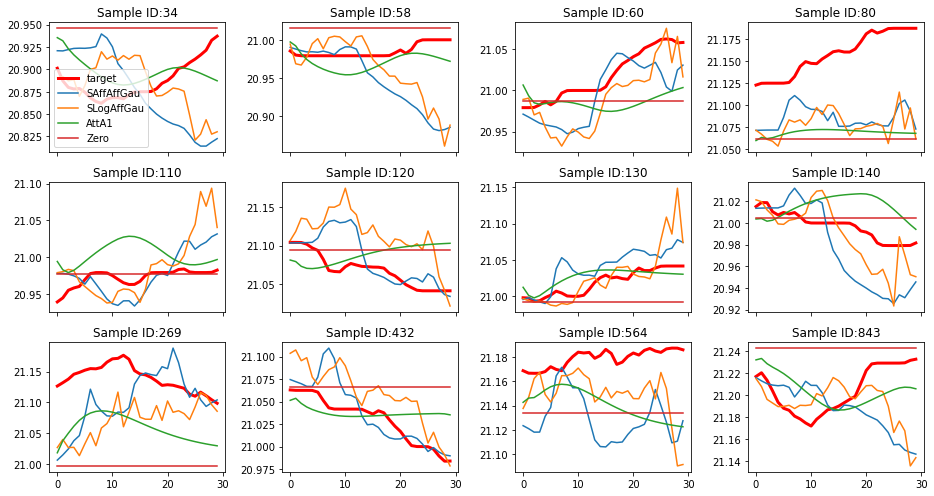

In [10]:
ids_to_plot = [34, 58, 60 , 80, 110, 120, 130, 140, 269, 432, 564, 843]
NCols = 4
NRows = int(len(ids_to_plot)/NCols) + 1 * (len(ids_to_plot) % NCols > 0)
fig, ax = plt.subplots(NRows, NCols, figsize=(13,7), sharex=True, sharey=False);
for k, sampleid in enumerate(ids_to_plot):
    gr = int(k / NCols)
    gc = int(k % NCols)
    ax[gr, gc].plot(scaled_targets[sampleid], 'r', linewidth=3, label='target')
    ax[gr, gc].set_title(f"Sample ID:{ids_to_plot[k]}")
    for i in range(len(model_names)):
        ax[gr, gc].plot(predictions[i][sampleid], label=model_names[i])
    
ax[0,0].legend()
fig.tight_layout()    

### Average loss with respect to the future.

One can expect that the distant future is predicted worse than near future. But how much worse? Linear? Exponentially worse?

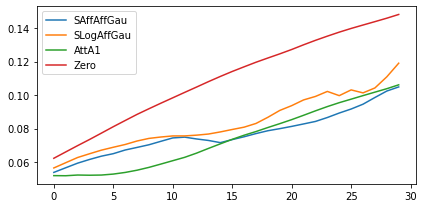

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6,3), sharex=True, sharey=True);
for i in range(len(model_names)):
    ax.plot(maes_timewise[i],  label=model_names[i])
ax.legend()
fig.tight_layout()    

    